# Preprocessing original 110x110 image into 64x64 image, then slicing them into 4x4 patches

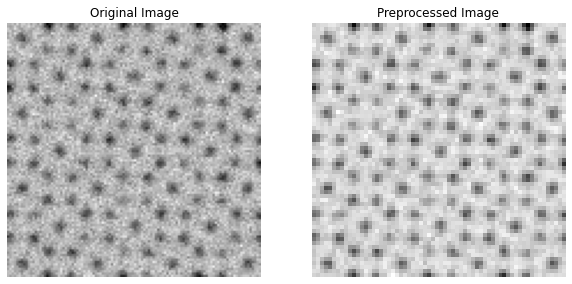

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path, size=(64,64)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

# Load and display the original image
image_path = 'Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e3dpa.png'  # Replace with your image path
original_img = Image.open(image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Preprocess the image
img_array = preprocess_image(image_path)

plt.subplot(1, 2, 2)
plt.imshow(img_array, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

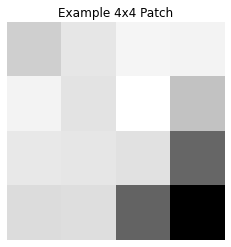

In [5]:
#attempting to slice images

import os

def pre_process(image_path, size=(64,64)):
    # loading the image and converting to grayscale
    img = Image.open(image_path).convert('L')
    # resizing image
    img_resized = img.resize(size)
    # converting to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

def save_patches(img_array, patch_size=(4,4), output_folder="patches"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    h, w = img_array.shape
    patch_h, patch_w = patch_size
    
    patch_idx = 0
    for i in range(0, h, patch_h):
        for j in range(0, w, patch_w):
            patch = img_array[i:i+patch_h, j:j+patch_w]
            patch_img = Image.fromarray((patch * 255).astype(np.uint8))
            patch_img.save(os.path.join(output_folder, f"patch_{patch_idx:03d}.png"))
            patch_idx +=1
        
# running code
image_path = 'Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e3dpa.png'

img_array = preprocess_image(image_path)

save_patches(img_array, patch_size=(4,4), output_folder="patches")

# testing to see if it worked
example_patch = Image.open("patches/patch_000.png")
plt.imshow(example_patch, cmap='gray')
plt.title("Example 4x4 Patch")
plt.axis('off')
plt.show()

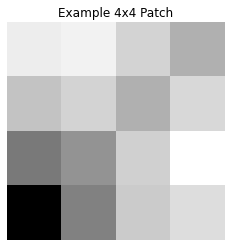

In [6]:
example_patch = Image.open("patches/patch_001.png")
plt.imshow(example_patch, cmap='gray')
plt.title("Example 4x4 Patch")
plt.axis('off')
plt.show()

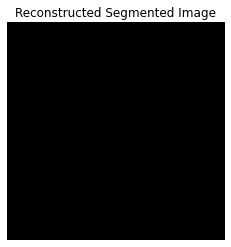

In [10]:
# rewriting the encoding and visualization codes to loop over all 256 images

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import circuit_drawer
# from qiskit import execute
from PIL import Image
import matplotlib.pyplot as plt
from qiskit.circuit.library import MCXGate

%matplotlib inline

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import circuit_drawer
# from qiskit import execute
from PIL import Image
import matplotlib.pyplot as plt
from qiskit.circuit.library import MCXGate

%matplotlib inline

def preprocess_image(image_path, size=(5,5)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

def create_oracle(img_array, threshold=0.5):
    size = img_array.shape[0]
    n_qubits = size * size
    oracle_qc = QuantumCircuit(n_qubits)
    
    # Apply X gates for pixels below the threshold
    for i, pixel in enumerate(img_array.flatten()):
        if pixel < threshold:
            oracle_qc.x(i)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    oracle_qc.append(mcx, list(range(n_qubits)))
    
    return oracle_qc.to_gate(label='Oracle')

def diffusion_operator(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    qc.append(mcx, list(range(n_qubits)))
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    return qc.to_gate(label='Diffusion')

def apply_grovers_search(qc, oracle, n_iterations=1):
    n_qubits = qc.num_qubits
    diffusion = diffusion_operator(n_qubits)
    
    for _ in range(n_iterations):
        qc.append(oracle, list(range(n_qubits)))
        qc.append(diffusion, list(range(n_qubits)))

def segment_patch(img_array, threshold=0.5, n_iterations=1):
    size = img_array.shape[0] # should be 4
    n_qubits = size*size
    
    # encoding
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # flatten image
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
            
    # creating oracle
    oracle = create_oracle(img_array, threshold)
    apply_grovers_search(qc, oracle, n_iterations)
    qc.measure(qr, cr)

    # Simulate
    simulator = Aer.get_backend('qasm_simulator')
    compiled = transpile(qc, simulator)
    result = simulator.run(assemble(compiled)).result()
    counts = result.get_counts()

    return interpret_results(counts, size)

def interpret_results(counts, size):
    segmented_image = np.zeros((size, size))
    max_index = size*size
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(' ', '')  # ensure no whitespace
        if len(bitstring) > int(np.ceil(np.log2(max_index))): #skip overlong bitstrings
            continue
        
        index = int(bitstring, 2)
        if index < max_index:
            row = index // size
            col = index % size
            segmented_image[row, col] =1
            
    return segmented_image

def process_all_patches(patch_folder="patches", patch_size=4, output_size=64):
    segmented_image = np.zeros((output_size, output_size))
    patch_files = sorted(os.listdir(patch_folder))

    idx = 0
    for row in range(0, output_size, patch_size):
        for col in range(0, output_size, patch_size):
            patch_path = os.path.join(patch_folder, patch_files[idx])
            img_array = preprocess_image(patch_path, size=(patch_size, patch_size))
            segmented_patch = segment_patch(img_array)

            segmented_image[row:row+patch_size, col:col+patch_size] = segmented_patch
            idx += 1

    return segmented_image


# testing
final_segmented_image = process_all_patches()
plt.imshow(final_segmented_image, cmap='gray')
plt.title("Reconstructed Segmented Image")
plt.axis('off')
plt.show()

In [17]:
# ignore black image. i don't think this was a valid approach. could've just coded something wrong too
# below are more methods i take to reconstruct the images

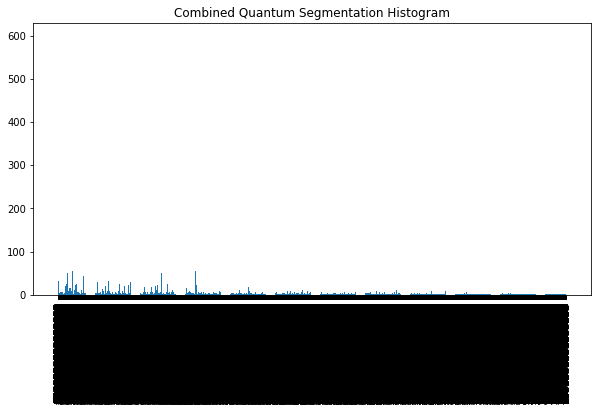

In [11]:
from collections import Counter

def process_all_histograms(patch_folder="patches", patch_size=4):
    total_counts = Counter()
    patch_files = sorted(os.listdir(patch_folder))

    for patch_path in patch_files:
        full_path = os.path.join(patch_folder, patch_path)
        img_array = preprocess_image(full_path, size=(patch_size, patch_size))

        size = img_array.shape[0]
        n_qubits = size * size

        qr = QuantumRegister(n_qubits)
        cr = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(qr, cr)

        flat_img = img_array.flatten()
        for i, pixel in enumerate(flat_img):
            if pixel > 0:
                qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])

        oracle = create_oracle(img_array)
        apply_grovers_search(qc, oracle)
        qc.measure(qr, cr)

        simulator = Aer.get_backend('qasm_simulator')
        compiled = transpile(qc, simulator)
        result = simulator.run(assemble(compiled)).result()
        counts = result.get_counts()

        # Accumulate counts from all patches
        total_counts.update(counts)

    return total_counts

all_counts = process_all_histograms()

plt.figure(figsize=(10, 5))
plt.bar(all_counts.keys(), all_counts.values())
plt.title("Combined Quantum Segmentation Histogram")
plt.xticks(rotation=90)
plt.show()

In [12]:
row in range(0,64,4)
col in range(0,64,4)

NameError: name 'row' is not defined

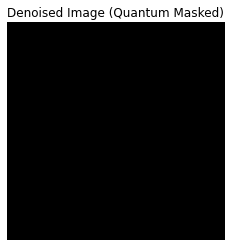

In [13]:
def apply_mask_to_original(original_image_path, segmented_mask):
    # Load original image and resize to 64x64
    img = Image.open(original_image_path).convert('L').resize(segmented_mask.shape)
    img_array = np.array(img) / 255.0

    # Apply segmentation mask
    denoised = img_array * segmented_mask

    return denoised

denoised_image = apply_mask_to_original('Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e3dpa.png', final_segmented_image)

plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image (Quantum Masked)")
plt.axis('off')
plt.show()

In [14]:
# that didn't work, let's try constructing based on histogram

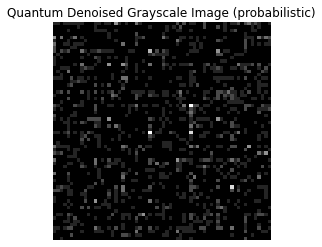

In [15]:
def histogram_to_grayscale_patch(counts, patch_size):
    pixel_counts = np.zeros(patch_size * patch_size)
    
    total_counts = sum(counts.values())
    if total_counts == 0:
        return np.zeros((patch_size, patch_size)) # all black if no data
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(' ','')
        index = int(bitstring, 2)
        if index < patch_size * patch_size:
            pixel_counts[index] += count
            
    pixel_probs = pixel_counts / total_counts # normalizing
    return pixel_probs.reshape((patch_size, patch_size))

def segment_patch_prob(img_array, threshold=0.5, n_iterations=1):
    size = img_array.shape[0]
    n_qubits = size*size
    
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
            
    oracle = create_oracle(img_array, threshold)
    apply_grovers_search(qc, oracle, n_iterations)
    qc.measure(qr, cr)
    
    simulator = Aer.get_backend('qasm_simulator')
    compiled = transpile(qc, simulator)
    result = simulator.run(assemble(compiled), shots=512).result()
    counts = result.get_counts()
    return histogram_to_grayscale_patch(counts, size)

def process_all_patch_prob(patch_folder="patches", 
                           patch_size=4, output_size=64):
    reconstructed_image =np.zeros((output_size, output_size))
    patch_files = sorted(os.listdir(patch_folder))
    
    idx = 0
    for row in range(0, output_size, patch_size):
        for col in range(0, output_size, patch_size):
            patch_path = os.path.join(patch_folder, patch_files[idx])
            img_array = preprocess_image(patch_path, size=(patch_size, patch_size))
            grayscale_patch = segment_patch_prob(img_array)
            reconstructed_image[row:row+patch_size, col:col+patch_size
                               ] = grayscale_patch
            idx += 1
    return reconstructed_image

# testing
final_grayscale_image = process_all_patch_prob()
plt.imshow(final_grayscale_image, cmap='gray')
plt.title("Quantum Denoised Grayscale Image (probabilistic)")
plt.axis('off')
plt.show()

In [20]:
# looks like this didn't work like I wanted. let's try something else
# having some difficulty thinking about the approach to take 
# methods i have in mind might involve sobel edge detection to help with the reconstruction
# maybe change the oracle? 

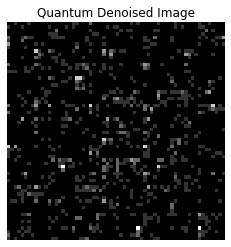

In [28]:
from scipy.ndimage import sobel, gaussian_filter

# preprocessing

def preprocess_image(image_path, size=(4, 4)):
    img = Image.open(image_path).convert('L')
    img_resized = img.resize(size)
    img_array = np.array(img_resized) / 255.0
    return img_array

def histogram_to_grayscale_patch(counts, patch_size):
    pixel_counts = np.zeros(patch_size * patch_size)
    total_counts = sum(counts.values())
    if total_counts == 0:
        return np.zeros((patch_size, patch_size))
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(' ', '')
        index = int(bitstring, 2)
        if index < patch_size * patch_size:
            pixel_counts[index] += count
    pixel_probs = pixel_counts / total_counts
    return pixel_probs.reshape((patch_size, patch_size))

# constructing the quantum circuit

def create_oracle(oracle_mask, threshold=0.5):
    size = oracle_mask.shape[0]
    n_qubits = size * size
    oracle_qc = QuantumCircuit(n_qubits)
    for i, pixel in enumerate(oracle_mask.flatten()):
        if pixel < threshold:
            oracle_qc.x(i)
    mcx = MCXGate(n_qubits - 1)
    oracle_qc.append(mcx, list(range(n_qubits)))
    return oracle_qc.to_gate(label='Oracle')

def diffusion_operator(n_qubits):
    qc = QuantumCircuit(n_qubits)
    for qubit in range(n_qubits):
        qc.h(qubit)
    for qubit in range(n_qubits):
        qc.x(qubit)
    mcx = MCXGate(n_qubits - 1)
    qc.append(mcx, list(range(n_qubits)))
    for qubit in range(n_qubits):
        qc.x(qubit)
    for qubit in range(n_qubits):
        qc.h(qubit)
    return qc.to_gate(label='Diffusion')

def apply_grovers_search(qc, oracle, n_iterations=1):
    n_qubits = qc.num_qubits
    diffusion = diffusion_operator(n_qubits)
    for _ in range(n_iterations):
        qc.append(oracle, list(range(n_qubits)))
        qc.append(diffusion, list(range(n_qubits)))
        
# developing a quantum segmentation function with structural oracle

def segment_patch_structural(img_array, method="sobel", threshold=0.1,
                            n_iterations=1):
    size = img_array.shape[0]
    n_qubits = size*size
    
    if method == "sobel":
        edge_map = np.hypot(sobel(img_array, axis=0),
                           sobel(img_array, axis=1))
    elif method == "gaussian_diff":
        edge_map = np.abs(img_array - gaussian_filter(img_array, sigma=1))
    else:
        edge_map = img_array.copy()
        
    oracle_mask = (edge_map > threshold).astype(float)
    
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)

    for i, pixel in enumerate(img_array.flatten()):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])

    oracle = create_oracle(oracle_mask, threshold=0.5)
    apply_grovers_search(qc, oracle, n_iterations)
    qc.measure(qr, cr)

    simulator = Aer.get_backend('qasm_simulator')
    result = simulator.run(transpile(qc, simulator), shots=512).result()
    counts = result.get_counts()
    return histogram_to_grayscale_patch(counts, size)

# reconstructing the image

def process_all_patches_structural(patch_folder="patches", patch_size=4,
                                  output_size=64, method="sobel",
                                  threshold=0.1):
    reconstructed_image = np.zeros((output_size, output_size))
    patch_files = sorted(os.listdir(patch_folder))
    idx = 0
    for row in range(0, output_size, patch_size):
        for col in range(0, output_size, patch_size):
            patch_path = os.path.join(patch_folder, patch_files[idx])
            img_array = preprocess_image(patch_path, size=(patch_size, 
                                                           patch_size))
            grayscale_patch = segment_patch_structural(img_array,
                                                      method=method,
                                                      threshold=threshold)
            reconstructed_image[row:row+patch_size, 
                                col:col+patch_size] = grayscale_patch
            idx += 1
    return reconstructed_image

# testing
final_image = process_all_patches_structural(method="sobel", threshold=0.05)
plt.imshow(final_image, cmap='gray')
plt.title("Quantum Denoised Image")
plt.axis('off')
plt.show()

In [31]:
#still didn't work
# maybe im thinking about this all wrong because 
# grover's search and our algorithms are probabilistic
# so maybe i can't just reconstruct the image immediately
# these are just probabilities, so the reconstruction would depend on qml?

In [32]:
# different approach and thought process
# need to remember that we are doing a classical-quantum-classical workflow
# so the decoding aspect should primarily be quantum-> classical